In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def gaussianLPF(BT, Tb, L, k):
    """
    Function to generate filter coefficients of Gaussian low pass filter (used in gmsk_mod)
    Parameters:
        BT : BT product - Bandwidth x bit period
        Tb : bit period
        L : oversampling factor (number of samples per bit)
        k : span length of the pulse (bit interval)        
    Returns:
        h_norm : normalized filter coefficients of Gaussian LPF
    """
    B = BT / Tb # bandwidth of the filter
    t = np.arange( start = -k * Tb, stop = k * Tb + Tb / L, step = Tb / L ) # truncated time limits for the filter
    h = B * np.sqrt( 2 * np.pi / np.log(2) ) * np.exp( -2 * ( t * np.pi * B )** 2 / np.log(2) )
    h_norm = h / np.sum(h)
    return h_norm

In [20]:
def gmsk_mod(a,fc,L,BT,enable_plot=False):
    """
    Function to modulate a binary stream using GMSK modulation
    Parameters:
        BT : BT product (bandwidth x bit period) for GMSK
        a : input binary data stream (0's and 1's) to modulate
        fc : RF carrier frequency in Hertz
        L : oversampling factor
        enable_plot: True = plot transmitter waveforms (default False)
    Returns:
        (s_t,s_complex) : tuple containing the following variables
            s_t : GMSK modulated signal with carrier s(t)
            s_complex : baseband GMSK signal (I+jQ)
    """
    from scipy.signal import upfirdn,lfilter
    
    fs = L*fc; Ts=1/fs;Tb = L*Ts; # derived waveform timing parameters
    c_t = upfirdn(h=[1]*L, x=2*a-1, up = L) #NRZ pulse train c(t)
    
    k=1 # truncation length for Gaussian LPF
    h_t = gaussianLPF(BT,Tb,L,k) # Gaussian LPF with BT=0.25
    b_t = np.convolve(h_t,c_t,'full') # convolve c(t) with Gaussian LPF to get b(t)
    bnorm_t = b_t/max(abs(b_t)) # normalize the output of Gaussian LPF to +/-1
    
    h = 0.5;
    phi_t = lfilter(b = [1], a = [1,-1], x = bnorm_t*Ts) * h*np.pi/Tb # integrate to get phase information
    
    I = np.cos(phi_t)
    Q = np.sin(phi_t) # cross-correlated baseband I/Q signals
    
    s_complex = I - 1j*Q # complex baseband representation
    t = Ts* np.arange(start = 0, stop = len(I)) # time base for RF carrier
    sI_t = I*np.cos(2*np.pi*fc*t); sQ_t = Q*np.sin(2*np.pi*fc*t)
    s_t = sI_t - sQ_t # s(t) - GMSK with RF carrier
    
    if enable_plot:
        fig, axs = plt.subplots(2, 4, figsize=(16,10))
        axs[0,0].plot(np.arange(0,len(c_t))*Ts,c_t);axs[0,0].set_title('c(t)');axs[0,0].set_xlim(0,40*Tb)
        axs[0,1].plot(np.arange(-k*Tb,k*Tb+Ts,Ts),h_t);axs[0,1].set_title('$h(t): BT_b$='+str(BT))
        axs[0,2].plot(t,I,'--');axs[0,2].plot(t,sI_t,'r');axs[0,2].set_title('$I(t)cos(2 \pi f_c t)$');axs[0,2].set_xlim(0,10*Tb)
        axs[0,3].plot(t,Q,'--');axs[0,3].plot(t,sQ_t,'r');axs[0,3].set_title('$Q(t)sin(2 \pi f_c t)$');axs[0,3].set_xlim(0,10*Tb)
        axs[1,0].plot( np.arange(0,len(bnorm_t))*Ts,bnorm_t);axs[1,0].set_title('b(t)');axs[1,0].set_xlim(0,40*Tb)
        axs[1,1].plot(np.arange(0,len(phi_t))*Ts, phi_t);axs[1,1].set_title('$\phi(t)$')
        axs[1,2].plot(t,s_t);axs[1,2].set_title('s(t)');axs[1,2].set_xlim(0,20*Tb)
        axs[1,3].plot(I,Q);axs[1,3].set_title('constellation')
        
    return (s_t,s_complex)

In [21]:
def gaussianBaseband(a, Rb, L, BT, enable_plot=False):
    """
    Function to modulate a binary stream using GMSK modulation
    Parameters:
        a  : input binary data stream (0's and 1's) to modulate
        Rb : bit rate
        L  : oversampling factor
        BT : BT product (bandwidth x bit period) for GMSK        
    Returns:
        (s_t,s_complex) : tuple containing the following variables
            s_t : GMSK modulated signal with carrier s(t)
            s_complex : baseband GMSK signal (I+jQ)
    """
    from scipy.signal import upfirdn
    
    Tb = 1 / Rb; # bit period
    c_t = upfirdn(h=[1]*L, x=2*a-1, up = L) #NRZ pulse train c(t)
    
    k=1 # truncation length for Gaussian LPF
    h_t = gaussianLPF(BT,Tb,L,k) # Gaussian LPF with BT=0.25
    b_t = np.convolve(h_t,c_t,'full') # convolve c(t) with Gaussian LPF to get b(t)
    bnorm_t = b_t / max( abs(b_t) ) # normalize the output of Gaussian LPF to +/-1
    
    if enable_plot:
        Ts = 1 / (L*Rb)
        fig, axs = plt.subplots(2, figsize=(16,10))
        axs[0].plot(np.arange(0,len(c_t))*Ts,c_t);axs[0].set_title('c(t)');axs[0].set_xlim(0,40*Tb)
        axs[1].plot( np.arange(0,len(bnorm_t))*Ts,bnorm_t);axs[1].set_title('b(t)');axs[1].set_xlim(0,40*Tb)
    
    return bnorm_t

In [26]:
def compute_TED_gain(_sps, enable_plot=False):
    from scipy.signal import lfilter
    # Define some constants
    N_bits = 30000                    # Number of bits used for timing error analysis
    bit_rate = 9600
    bits_per_symbol = 1
    baud_rate = bit_rate / bits_per_symbol
    N_syms = int(N_bits / bits_per_symbol) # Number of symbols used for timing error analysis
    tea_sps = 100                     # samples/symbol used for timing error analysis
    tea_Fs = tea_sps * baud_rate      # sample rate used for timing error analysis
    sps = _sps                        # actual samples per symbol used in application
    Fs = sps * baud_rate              # actual sample rate used in application
    
    # Generate random bits
    bits = np.random.randint(0, 2, N_bits)
    
    # Generate baseband signal
    Ts = 1 / (tea_sps*bit_rate)
    Tb = 1 / bit_rate
    baseband = gaussianBaseband(bits, bit_rate, tea_sps, 1.0, enable_plot=False)
    #gmsk_mod(bits, 100, 8, 0.5, True)
    
    
    # Symbol centers are now at indices n*tea_sps + isi_sps/2
    # Symbol clock period is tea_sps samples
    # Symbol peaks are perfectly at +/-1.0
    isi_sps = 0
    mf_taps = 1/(tea_sps+isi_sps) * np.ones(tea_sps+isi_sps)
    mf_len = mf_taps.size
    mf_delay = mf_len/2
    
    # Matched filter the received baseband pulses
    mf_baseband = lfilter(mf_taps, 1, baseband);
    mf_baseband = mf_baseband * 1.0 # Play with amplitude to see S-curve effects
    fig, axs = plt.subplots(2, figsize=(16,10))
    
    if enable_plot:
        axs[0].plot(np.arange(0,len(baseband))*Ts,baseband);axs[0].set_title('b(t)');axs[0].set_xlim(0,40*Tb)
        axs[1].plot(np.ara
                    nge(0,len(mf_baseband))*Ts,mf_baseband);axs[1].set_title('mf_b(t)');axs[1].set_xlim(0,40*Tb)
    
    # Timing offset granularity is in 1/tea_sps of a symbol
    tau = np.arange(-tea_sps//2 + 2, tea_sps//2)
    tau_norm = tau / tea_sps * sps
    
    # Constellation points at -1.0 and +1.0
    # M&M TED
    # Gardner TED
    ## Assumptions:
    # Perfect estimate of symbol clock period
    # No external noise
    mm_ted_output = np.zeros((N_syms, tau.size));
    ga_ted_output = np.zeros((N_syms, tau.size));
    # For each known symbol peak set (M&M needs prev and current symbol)
    for i in range(1, N_syms-1):
        # Cycle through all the timing offsets around this symbol
        # using a perfect symbol clock period estimate
        opt_prev_idx = (i-1)*tea_sps + isi_sps//2;
        opt_curr_idx = i*tea_sps + isi_sps//2;
        for j, t in enumerate(tau):
            prev_soft_sym = mf_baseband[opt_prev_idx - t];
            mid_soft_samp = mf_baseband[(opt_curr_idx+opt_prev_idx)//2 - t];
            curr_soft_sym = mf_baseband[opt_curr_idx - t];
            prev_decision = 1 if prev_soft_sym >= 0 else -1
            curr_decision = 1 if curr_soft_sym >= 0 else -1
            mm_ted_output[i,j] = prev_decision * curr_soft_sym - curr_decision * prev_soft_sym
            ga_ted_output[i,j] = (prev_soft_sym - curr_soft_sym) * mid_soft_samp

    mean_mm_ted_output = np.average(mm_ted_output, axis = 0)
    mean_ga_ted_output = np.average(ga_ted_output, axis = 0)
    # Plot the S-Curves
#     plt.figure()
#     plt.plot(tau_norm, mean_mm_ted_output)
#     plt.plot(tau_norm, mean_ga_ted_output)
#     plt.xlabel('Timing Error from Symbol Center');
#     plt.ylabel('Expected Value of TED Output');
    
    tau_diff = tau[:-1]+0.5;
    tau_diff_norm = tau_diff/tea_sps*sps;
    diff_mm_ted_output = np.diff(mean_mm_ted_output)/(sps/tea_sps);
    diff_ga_ted_output = np.diff(mean_ga_ted_output)/(sps/tea_sps);
    k = diff_mm_ted_output.size
    mm_ted_gain = np.average(diff_mm_ted_output[(k-1)//2:(k-1)//2+2])
    k = diff_ga_ted_output.size
    ga_ted_gain = np.average(diff_ga_ted_output[(k-1)//2:(k-1)//2+2])
    
    return (mm_ted_gain*sps, ga_ted_gain*sps)

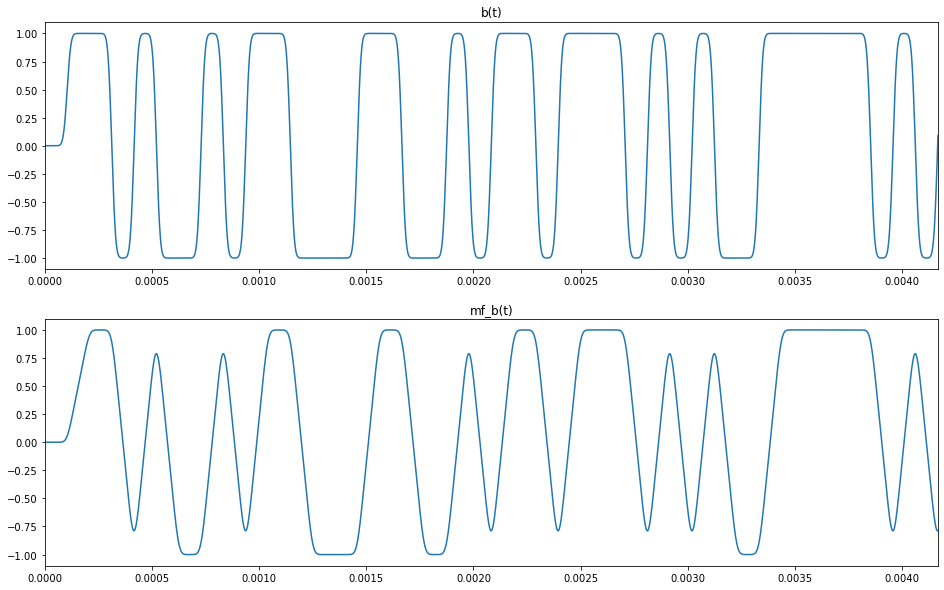

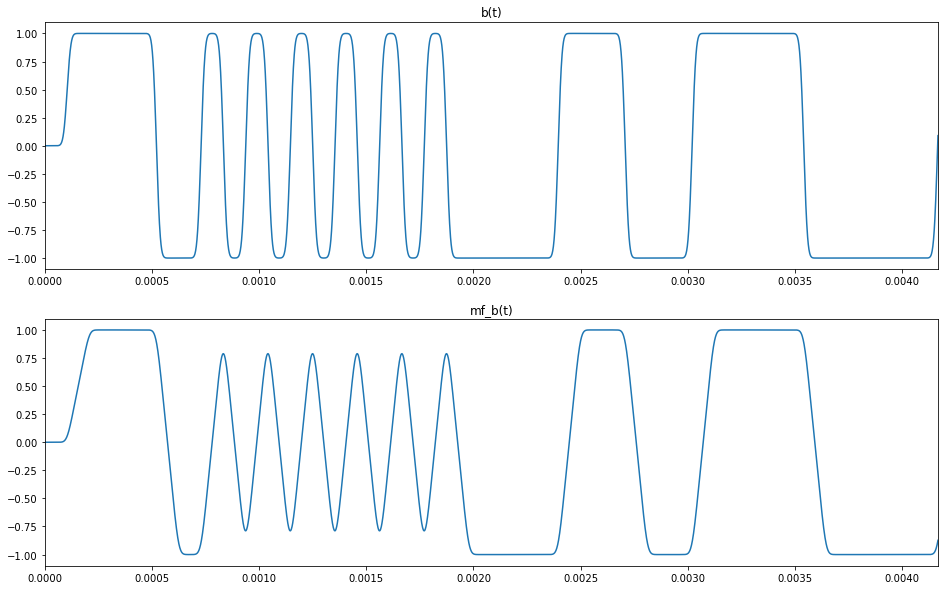

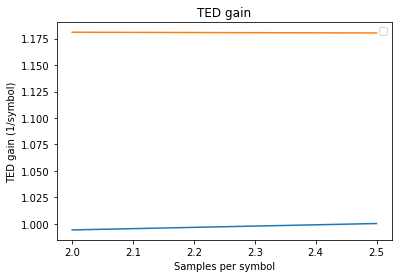

In [28]:
sps = np.arange(2, 3, 0.5)
gains = [compute_TED_gain(s, enable_plot=True) for s in sps]

plt.figure()
plt.title('TED gain')
plt.ylabel('TED gain (1/symbol)')
plt.xlabel('Samples per symbol')
plt.legend(['M&M TED', 'Gardner TED'])
plt.plot(sps, np.array([g[0] for g in gains]))
plt.plot(sps, np.array([g[1] for g in gains]))